# Aine Code

Text(0, 0.5, 'Neuron')

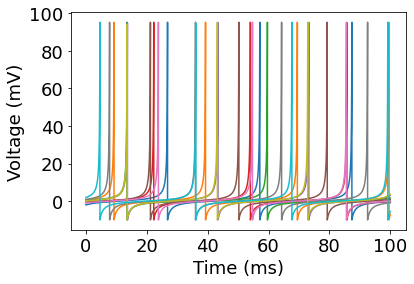

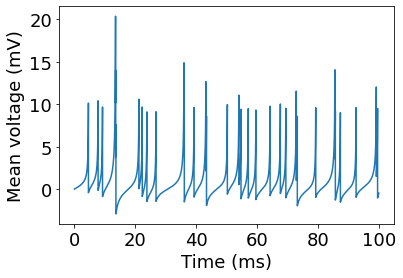

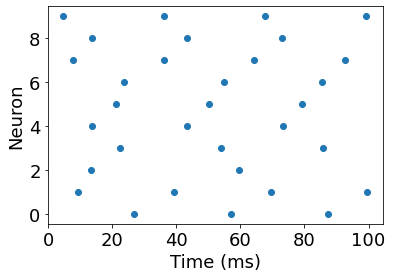

In [122]:
# Quadratic integrate and fire network
# 27-09-2024

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import solve_ivp
import seaborn as sns

np.random.seed(101)

# Numerical parameters
N = 10              # Number of neurons
T = 100             # Final time in ms
M = 50000              # max number spikes
dt = 0.005
t0 = 0

# Model parameters
tauV = 10
eta0 = 1
delta = 0.05
vsyn = 0
k = 1
tauS = 3
vth = 100 
vreset = -10 

eta = stats.cauchy.rvs(loc=eta0, scale=delta, size=(N))


# Initialise variables
v_init = np.random.normal(0,1, size=(N)) 
s_init = np.zeros(v_init.shape)

v0 = v_init
s0 = s_init

t_all = np.array([t0])
y_0 = np.concatenate([v0, s0])
y_all = np.reshape(y_0, (y_0.shape[0], 1)) 


def dxdt(t, x, tauV, eta, vsyn, k, vth):
    v = x[:N]
    s = x[N:2*N]

    dvdt = ( pow(v,2) + eta + k*s*(vsyn-v) ) / tauV
    dsdt = -s/tauS

    return np.concatenate([dvdt, dsdt])

def v_spike(t, x, tauV, eta, vsyn, k, vth):

    return max(x[:N]) - vth
v_spike.terminal = True
v_spike.direction = 1 


# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

while i < M and t0 < T:
    y0 = np.concatenate([v0, s0])
    sol_v = solve_ivp(dxdt, [t0, T], y0, args = (tauV, eta, vsyn, k, vth), dense_output=True, events=v_spike, rtol=1e-8)
    t_end = sol_v.t[-1]
    steps = max([2,int((t_end -  t0)/dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all,t[:-1]],axis=0)
    y_all = np.concatenate([y_all,y[:,:-1]],axis=1)
    
    t0 = t_end
    v0 = y[:N,-1]
    s0 = y[N:2*N,-1]
    
    if len(sol_v.t_events[0])>0:
        
        spike = v0.argmax()
        v0[spike] = vreset
        s0 += 1/(tauS*N)
        
        spike_times[spikeCounter,:] = [t0, spike]
        spikeCounter = spikeCounter + 1
        
        i += 1
       

colours = sns.color_palette('deep')
font = {'family': 'Times',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)
# plt.rcParams['text.usetex'] = True
 

plt.figure()
plt.plot(t_all,y_all[:N,:].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')   

plt.figure()
plt.plot(t_all,y_all[:N,:].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter,:]
plt.figure()  
plt.scatter(spike_times[:,0],spike_times[:,1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

Text(0, 0.5, 'Neuron')

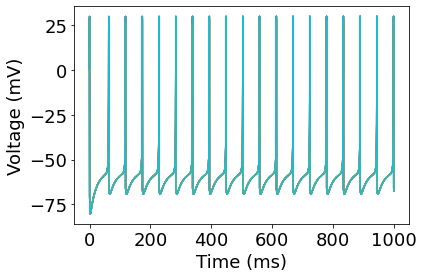

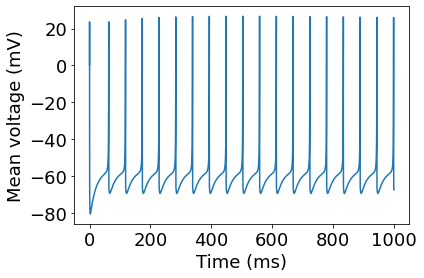

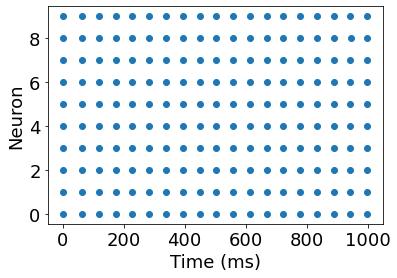

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
from scipy.interpolate import interp1d

np.random.seed(101)

N = 10          
T = 1000               
M = 50000             
dt = 0.005            
t0 = 0                

k = 1               
I = 0.15             
a = 0.1              
b = 0.26             
c = -65              
d = -1               
v_reset = c          
v_thresh = 30        

v_init = np.random.normal(0,1, size=(N)) 
u_init = np.zeros(v_init.shape)


t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0


def dxdt(t, x, k, a, b, I):
    v = x[:N]     
    u = x[N:2*N]  
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) 
    dudt = k * a * (b * v - u)  
    
    return np.concatenate([dvdt, dudt])


def v_spike(t, x, k, a, b, I):
    return x[:N].max() - v_thresh   
v_spike.terminal = True
v_spike.direction = 1


while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init])  
    
  
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])  
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)  
    
 
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]    
    u_init = y[N:2*N, -1] 
    
    # Check for spikes
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()  
        
        v_init[spike] = v_reset  
        u_init += 1/N   # u=====>u + d      
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1


colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)


plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')



plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')



spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

In [166]:
v_init

array([-67.45211112])

Text(0, 0.5, 'Neuron')

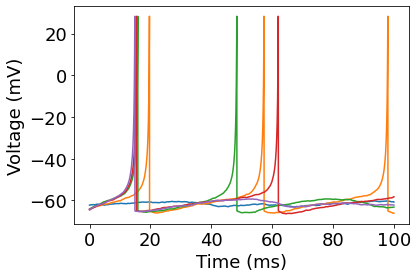

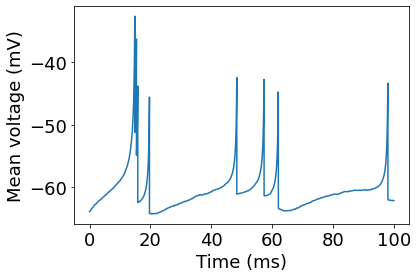

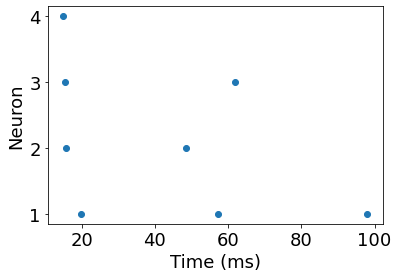

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
from scipy.interpolate import interp1d

# This code adds J
np.random.seed(101)

N = 5            
T = 100               
M = 50000             
dt = 0.005            
t0 = 0                

k = 1               
I = 0.15             
a = 0.1              
b = 0.26             
c = -65              
d = -1               
v_reset = c          
v_thresh = 30        

# Noise parameters
sigma_N = 0.5         # Noise amplitude / Standard Deviation


v_init = np.random.normal(-65, 1, size=(N))  
u_init = 0.26*v_init  

# Time points for noise sampling every 0.1 ms
noise_sample_times = np.arange(t0, T, 0.1)
noise_samples = np.random.normal(0, sigma_N, size=(len(noise_sample_times), N))

# Interpolate noise 
noise_interp = interp1d(noise_sample_times, noise_samples, kind='linear', axis=0, fill_value="extrapolate")


t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))


spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0


def dxdt(t, x, k, a, b, I):
    v = x[:N]     
    u = x[N:2*N]  
    
    J = noise_interp(t)
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J
    dudt = k * a * (b * v - u)  
    
    return np.concatenate([dvdt, dudt])


def v_spike(t, x, k, a, b, I):
    return x[:N].max() - v_thresh   
v_spike.terminal = True
v_spike.direction = 1


while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init])  
    
  
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])  
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)  
    
 
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]    
    u_init = y[N:2*N, -1] 
    
    # Check for spikes
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()  
        
        v_init[spike] = v_reset  
        u_init[spike] += d       
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1


colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)


plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')



plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')



spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

In [57]:
noise_interp(t).mean()

0.012475781461052972

In [58]:
# This code adds the synaptic current
E_syn = -70     
tau_rise = 2    
tau_fall = 5     
g_syn = np.zeros((N, N))  
f = 1 #Don't know how to define f

for j in range(N):
    connections = np.random.choice(np.delete(np.arange(N), j), 40, replace=False)
    g_syn[connections, j] = 0.03
alpha = np.zeros(N)
beta = np.zeros(N)
def dxdt(t, x, k, a, b, I, g_syn, E_syn):
    v = x[:N]
    u = x[N:2*N]
    alpha = x[2*N:3*N] #Don't know how to define alpha
    beta = x[3*N:4*N] #Don't know how to define beta
    s = alpha - beta
    synaptic_current = (v - E_syn) * np.sum(g_syn * s[:, np.newaxis], axis=0)
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - synaptic_current
    dudt = k * a * (b * v - u)
    dalphadt = -alpha / tau_rise
    dbetadt = -alpha / tau_fall
    return np.concatenate([dvdt, dudt, dalphadt, dbetadt])
def v_spike(t, x, k, a, b, I, g_syn, E_syn):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init])  
    
  
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])  
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)  
    
 
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]    
    u_init = y[N:2*N, -1]
    alpha = y[2*N:3*N, -1]
    beta = y[3*N:4*N, -1]
    
    
    # Check for spikes
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()  
        
        v_init[spike] = v_reset  
        u_init[spike] += d 
        alpha[strike] += f
        beta[spike] += f
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter += 1
        i += 1
colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)


plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')



plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')



spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

ValueError: 'a' cannot be empty unless no samples are taken